# Model Training from scratch (with and without DP)

In [ ]:
# [FIXED] for some reason it was throwing a ModuleNotFoundError, had to add Opacus path manually
# import sys
# sys.path.insert(0, r"/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages")

from importlib import reload
from models.tokenizers import RegexTokenizer
from models.MinGPT import *

from data.data_utils import *
from data.dataset import *

dataset_size = 'medium'
# TRAIN_DATA = 'data/sources/json/corpus_chr22.json'
TRAIN_DATA = f"/datasets/sources/train_gts_with_pop.json"
HOLDOUT_DATA = f"/datasets/sources/holdout_gts_with_pop.json"
VAL_DATA = f"/datasets/sources/val_gts_with_pop.json"

num_samples = 100 # 2504

In [21]:
import matplotlib.pyplot as plt

def expand_list(original_list, size):
    expanded_list = []
    step = size // len(original_list)
    idx = 0
    for item in original_list:
        expanded_list.append(item)
        while not (idx+1) % step == 0 and len(expanded_list) < size:
            # print(f"Adding element at index {added_ids}: {item}")
            expanded_list.append(item)
            # print('Adding element:', item, '(', idx, ')')
            idx += 1
        idx += 1
    return expanded_list

def plot_training_curves(trainer, config, savepath, bbox_to_anchor=(0.8, 0.6)):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(trainer.saved_losses['train_losses'], label='training loss')
    ax.plot(expand_list(trainer.saved_losses['eval_losses'],
                        len(trainer.saved_losses['train_losses'])),
                        label='eval loss')

    title = "Losses"
    if config.use_privacy:
        ax2 = ax.twinx()
        if len(trainer.used_epsilons) == len(trainer.saved_losses['train_losses']):
            ax2.plot(trainer.used_epsilons, label='ε used', color='green')
        else:
            ax2.plot(expand_list(trainer.used_epsilons,
                    len(trainer.saved_losses['train_losses'])), 
                     label='ε used', color='green')
        ax2.set_ylabel("Epsilon")
        title += " and Epsilon"
    title += " Over Training Epochs"

    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss")   
    plt.title(title)
    fig.legend(bbox_to_anchor=bbox_to_anchor,title='Legend', title_fontproperties={'weight': 'bold'})
    if savepath:
        plt.savefig(savepath, bbox_inches='tight', format='pdf')
    plt.show()

# A. minGPT

**IDEA**: smaller model = less prone to memorization → better for DP?

In [4]:
set_seed(42)

### Training

In [6]:
# Initialize config
config = MinGPTConfig(dataset_size)
config.train_data_path = TRAIN_DATA
config.val_data_path = VAL_DATA
# config.batch_size = 4
config.num_epochs = 50

print(config)

Using CUDA GPU
MinGPT Configuration
Model Architecture:
  Vocab size: 4104
  Block Size: 4676
  Num Layers: 6
  Num Heads: 6
  Embedding Size: 384

Model Max Length: 4676
Batch Size: 16
Learning Rate: 0.001
Weight Decay: 0.1
Num Epochs: 50
Optimizer: adam


In [7]:
# Initialize tokenizer
tokenizer = RegexTokenizer()
tokenizer.load()
GPT_SPECIAL_TOKENS = {'<START_SAMPLE>': 4096,
                    '<END_SAMPLE>': 4097,
                    '<MUT_SEP>': 4098,
                    '<START_ID>': 4099,
                    '<END_ID>': 4100,
                    '<START_POP>': 4101,
                    '<END_POP>': 4102,
                    '<PAD>': 4103,
                    '<UNK>': 4104}
tokenizer.register_special_tokens(GPT_SPECIAL_TOKENS)
tokenizer.special_tokens = GPT_SPECIAL_TOKENS

# test sample sequence
start_sequence = '22:17705808:C>T_2|1 22:18018960:T>C_3|0 <|endoftext|>'
print(tokenizer.decode(tokenizer.encode(start_sequence, allowed_special='all')))
# config.vocab_size = len(tokenizer.vocab)

22:17705808:C>T_2|1 22:18018960:T>C_3|0


In [8]:
print("Setting up model and trainer...")
model = MinGPT(config)
print(model)
# Initialize trainer
trainer = MinGPTTrainer(config=config, model=model, tokenizer=tokenizer)
# print(f"Vocabulary size: {len(trainer.tokenizer.vocab)}")

Setting up model and trainer...
Model has 12.20M parameters.
MinGPT(
  (transformer): ModuleDict(
    (wte): Embedding(4104, 384)
    (wpe): Embedding(4676, 384)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-5): 6 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=384, out_features=1152, bias=False)
          (c_proj): Linear(in_features=384, out_features=384, bias=False)
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=384, out_features=1536, bias=False)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=1536, out_features=384, bias=False)
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=384, out_features=4104, bias=False)
)


In [9]:
print("Loading and formatting dataset...")
special_mingpt_tokens = {'start_sample': '<START_SAMPLE>',
                    'end_sample': '<END_SAMPLE>',
                    'mutation_sep': ' ',
                    'pad_token': '<PAD>',
                    'unk_token': '<UNK>'}
formatter = GPTDataFormatter(custom=True, special_tokens=special_mingpt_tokens)

# Load data
original_genotypes = formatter.load_data_from_json(config.train_data_path)
print(f"   Loaded {len(original_genotypes)} samples")
# Format data
formatted_genotype_seqs = formatter.get_training_corpus(original_genotypes)
print(f"   Formatted {len(formatted_genotype_seqs)} sample sequences")

# Prepare datasets
train_dataloader, eval_dataloader = trainer.setup_training_data(formatted_genotype_seqs)
print(f"   Training samples: {len(train_dataloader.dataset)}")
print(f"   Evaluation samples: {len(eval_dataloader.dataset)}")

Loading and formatting dataset...
   Loaded 1752 samples
   Formatted 1752 sample sequences
   Training samples: 1226
   Evaluation samples: 526


In [12]:
torch.cuda.empty_cache()

In [10]:
print("Training model...")

trainer.run(train_dataloader, eval_dataloader)

Training model...
    Num decayed parameter tensors: 26, with 13,988,352 parameters
    Num non-decayed parameter tensors: 13, with 4,992 parameters
    Using AdamW as optimizer


Epoch 1/50:   0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
Epoch 50/50: 100%|██████████| 50/50 [3:46:12<00:00, 271.46s/it, iter_dt 272794.57ms;	lr: 0.001	train_loss: 0.0348	eval_loss: 0.0313]  

Saved checkpoint: models/saved/minGPT/checkpoints/checkpoint_epoch_50.pth


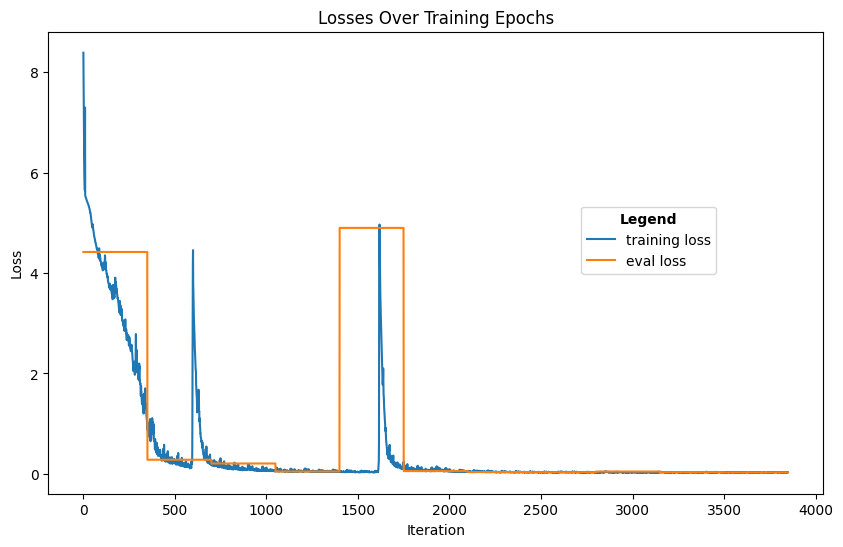

In [14]:
plot_training_curves(trainer, config, savepath=f'figures/minGPT_{dataset_size}_training_plot.pdf')

In [12]:
# Save final model
saved_model_path = f'models/saved/minGPT/minGPT_noDP_{dataset_size}.pth'
torch.save(model, saved_model_path)

print(f"Training completed!\nModel saved at {saved_model_path}.")

Training completed!
Model saved at models/saved/minGPT/minGPT_noDP_medium.pth.


___

### Inference

In [16]:
# Load trained model
# saved_model_path = f'models/saved/minGPT/minGPT_noDP_{dataset_size}.pth'
saved_model_path = f'models/saved/minGPT/minGPT_noDP_{dataset_size}.pth'

model = MinGPT.from_pretrained(saved_model_path)
print(model)

MinGPT(
  (transformer): ModuleDict(
    (wte): Embedding(4104, 384)
    (wpe): Embedding(4676, 384)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-5): 6 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=384, out_features=1152, bias=False)
          (c_proj): Linear(in_features=384, out_features=384, bias=False)
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=384, out_features=1536, bias=False)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=1536, out_features=384, bias=False)
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=384, out_features=4104, bias=False)
)


In [17]:
config = MinGPTConfig(dataset_size)
config.max_length = 4676 #4676 # max sample length
config.block_size = 4676 #4676 # block size
# Load trained tokenizer
tokenizer = RegexTokenizer()
tokenizer.load()
GPT_SPECIAL_TOKENS = {'<START_SAMPLE>': 4096,
                    '<END_SAMPLE>': 4097,
                    '<MUT_SEP>': 4098,
                    '<START_ID>': 4099,
                    '<END_ID>': 4100,
                    '<START_POP>': 4101,
                    '<END_POP>': 4102,
                    '<PAD>': 4103,
                    '<UNK>': 4104}
tokenizer.register_special_tokens(GPT_SPECIAL_TOKENS)
tokenizer.special_tokens = GPT_SPECIAL_TOKENS

# create trainer with trained model
trainer = MinGPTTrainer(config=config, model=model.to('cpu'), tokenizer=tokenizer)


Using CUDA GPU


In [24]:
# Generate synthetic samples
TRAIN_DATA = f"/datasets/sources/train_gts_with_pop.json"
train_data = json.load(open(TRAIN_DATA, 'r'))

sample_ids = list(train_data.keys())
num_samples = 50
num_mutations = 1000

synthetic_sequences = []
for i,sample in enumerate(sample_ids[:num_samples]):
    print(f"\nGenerating sample {i+1}...")
    start_prompt = train_data[sample]['genotypes'][:100]  # Use first 100 chars of genotype as prompt
    sequence = generate_synthetic_samples(model=model, tokenizer=tokenizer,
        max_sample_length=10*num_mutations,
        return_tensors=False,
        start_prompt=start_prompt,
        device= 'cuda' if torch.cuda.is_available() else 'cpu'
    )
    synthetic_sequences.extend(sequence)
    print(f"Generated sequence {i+1}: {sequence[-1][:100]}...\n")  # Show first 100 chars

synthetic_genotypes = {f'synth_{i+1}': seq for i, seq in enumerate(synthetic_sequences)}


Generating sample 1...
Generated sequence 1: 22:16056839:C>T_0|0 22:16059249:G>A_0|0 22:16059670:A>G_0|0 22:16059958:G>T_0|0 22:16061929:T>G_0|0 ...


Generating sample 2...
Generated sequence 2: 22:16056839:C>T_0|0 22:16059249:G>A_0|0 22:16059670:A>G_0|0 22:16059958:G>T_0|0 22:16061929:T>G_0|0 ...


Generating sample 3...
Generated sequence 3: 22:16056839:C>T_0|0 22:16059249:G>A_0|0 22:16059670:A>G_0|0 22:16059958:G>T_0|0 22:16061929:T>G_0|0 ...


Generating sample 4...
Generated sequence 4: 22:16056839:C>T_0|0 22:16059249:G>A_0|0 22:16059670:A>G_0|0 22:16059958:G>T_0|0 22:16061929:T>G_0|0 ...


Generating sample 5...
Generated sequence 5: 22:16056839:C>T_0|0 22:16059249:G>A_0|0 22:16059670:A>G_0|0 22:16059958:G>T_0|0 22:16061929:T>G_0|0 ...



In [21]:
from metrics import *
from data.data_utils import get_sequences_from_file

synthetic_genotypes = {f'synth_{i+1}': seq for i, seq in enumerate(synthetic_sequences)}
valid_sequences, valid_sequences_ratio, all_sequences = get_valid_sequences(synthetic_genotypes.values(),
                                                                            sample_wise=True)
training_gts = get_sequences_from_file(f'data/sources/json/{dataset_size}/train_gts_with_pop.json')
training_gts = [gt['genotypes'] for gt in training_gts]
original_valid_sequences, original_valid_sequences_ratio, all_original_sequences = get_valid_sequences(training_gts, has_sample_names=True)

unique_muts_gpt_pretrained, memorized_muts_gpt_pretrained = get_new_generated_mutations(valid_sequences,
                                                            original_sequences=all_original_sequences,
                                                            sample_wise=True, verbose=True)

Total muts: 49 >> Unique: 44, Memorized: 5
Total muts: 57 >> Unique: 53, Memorized: 4
Total muts: 53 >> Unique: 49, Memorized: 4
Total muts: 51 >> Unique: 47, Memorized: 4
Total muts: 51 >> Unique: 47, Memorized: 4


In [22]:
unique_sequences, unique_sequences_ratio = get_uniqueness_score(valid_sequences)
unique_sequences_ratio

[0.8367346938775511,
 0.8245614035087719,
 0.8301886792452831,
 0.7843137254901961,
 0.8627450980392157]

In [ ]:
# Generate synthetic samples
TRAIN_DATA = f'data/sources/json/{dataset_size}/train_gts_with_pop.json'
train_data = json.load(open(TRAIN_DATA, 'r'))

sample_ids = list(train_data.keys())
num_samples = 50
num_mutations = 500

synthetic_sequences = []
for i,sample in enumerate(sample_ids[:num_samples]):
    print(f"\nGenerating sample {i+1}...")
    start_prompt = train_data[sample]['genotypes'][:100]  # Use first 100 chars of genotype as prompt
    sequence = trainer.generate_synthetic_samples(
        max_sample_length=10*num_mutations,
        return_tensors=False,
        start_prompt=start_prompt,
    )
    synthetic_sequences.extend(sequence)
    print(f"Generated sequence {i+1}: {sequence[-1][:100]}...\n")  # Show first 100 chars


Generating sample 1...
Generated sequence 1: 22:16152222:C>T_0|0 22:16287622:A>G_0|0 22:16299653:C>T_0|0 22:16399805:G>A_0|0 22:16636563:A>G_0|0 ...


Generating sample 2...
Generated sequence 2: 22:16152222:C>T_0|0 22:16287622:A>G_0|0 22:16299653:C>T_0|0 22:16399805:G>A_0|0 22:16636563:A>G_0|0 ...


Generating sample 3...
Generated sequence 3: 22:16152222:C>T_0|0 22:16287622:A>G_0|0 22:16299653:C>T_0|0 22:16399805:G>A_0|0 22:16636563:A>G_0|0 ...


Generating sample 4...
Generated sequence 4: 22:16152222:C>T_0|0 22:16287622:A>G_0|0 22:16299653:C>T_0|0 22:16399805:G>A_0|0 22:16636563:A>G_0|1 ...


Generating sample 5...
Generated sequence 5: 22:16152222:C>T_0|0 22:16287622:A>G_0|0 22:16299653:C>T_0|0 22:16399805:G>A_0|0 22:16636563:A>G_0|0 ...


Generating sample 6...
Generated sequence 6: 22:16152222:C>T_0|0 22:16287622:A>G_0|0 22:16299653:C>T_0|0 22:16399805:G>A_0|0 22:16636563:A>G_0|0 ...


Generating sample 7...
Generated sequence 7: 22:16152222:C>T_0|0 22:16287622:A>G_0|0 22:16299

In [15]:
synthetic_genotypes = {f'synth_{i+1}': seq for i, seq in enumerate(synthetic_sequences)}

with open(f'data/generated/json/minGPT/mingpt_nodp.json', 'w+') as f:
    json.dump(synthetic_genotypes, f)

In [ ]:
from metrics import *
from data.data_utils import get_sequences_from_file

valid_sequences, valid_sequences_ratio, all_sequences = get_valid_sequences(synthetic_genotypes.values(),
                                                                            sample_wise=True)
training_gts = get_sequences_from_file(f'data/sources/json/{dataset_size}/train_gts_with_pop.json')
training_gts = [gt['genotypes'] for gt in training_gts]
original_valid_sequences, original_valid_sequences_ratio, all_original_sequences = get_valid_sequences(training_gts, has_sample_names=True)

unique_muts_gpt_pretrained, memorized_muts_gpt_pretrained = get_new_generated_mutations(valid_sequences,
                                                            original_sequences=all_original_sequences,
                                                            sample_wise=True, verbose=True)

Total muts: 954 >> Unique: 912, Memorized: 42
Total muts: 911 >> Unique: 876, Memorized: 35
Total muts: 932 >> Unique: 890, Memorized: 42
Total muts: 978 >> Unique: 942, Memorized: 36
Total muts: 943 >> Unique: 898, Memorized: 45
Total muts: 920 >> Unique: 893, Memorized: 27
Total muts: 919 >> Unique: 882, Memorized: 37
Total muts: 930 >> Unique: 884, Memorized: 46
Total muts: 955 >> Unique: 913, Memorized: 42
Total muts: 956 >> Unique: 917, Memorized: 39
Total muts: 916 >> Unique: 868, Memorized: 48
Total muts: 934 >> Unique: 883, Memorized: 51
Total muts: 910 >> Unique: 871, Memorized: 39
Total muts: 934 >> Unique: 888, Memorized: 46
Total muts: 957 >> Unique: 913, Memorized: 44
Total muts: 971 >> Unique: 929, Memorized: 42
Total muts: 935 >> Unique: 895, Memorized: 40
Total muts: 943 >> Unique: 917, Memorized: 26
Total muts: 936 >> Unique: 891, Memorized: 45
Total muts: 965 >> Unique: 936, Memorized: 29
Total muts: 926 >> Unique: 892, Memorized: 34
Total muts: 954 >> Unique: 916, Me

In [6]:
unique_sequences, unique_sequences_ratio = get_uniqueness_score(valid_sequences)
unique_sequences_ratio

[0.3972746331236897,
 0.39846322722283206,
 0.38197424892703863,
 0.3885480572597137,
 0.38812301166489926,
 0.43043478260869567,
 0.3895538628944505,
 0.3935483870967742,
 0.3968586387434555,
 0.3807531380753138,
 0.39737991266375544,
 0.39400428265524623,
 0.4032967032967033,
 0.4025695931477516,
 0.4012539184952978,
 0.3995880535530381,
 0.3732620320855615,
 0.41569459172852596,
 0.4155982905982906,
 0.39792746113989635,
 0.3930885529157667,
 0.37945492662473795,
 0.41952789699570814,
 0.4088514225500527,
 0.3908898305084746,
 0.36761710794297353,
 0.41120507399577166,
 0.43552036199095023,
 0.35854922279792745,
 0.40413943355119825,
 0.37327677624602335,
 0.4091403699673558,
 0.402425578831312,
 0.39344262295081966,
 0.3764172335600907,
 0.4055793991416309,
 0.3936052921719956,
 0.4287245444801715,
 0.39236479321314954,
 0.3873015873015873,
 0.4238197424892704,
 0.3973941368078176,
 0.3678646934460888,
 0.41368078175895767,
 0.38309549945115257,
 0.39831401475237094,
 0.37391304347

In [37]:
rare_muts = open(f'data/sources/rare_snps.txt', 'r').readlines()
rare_muts = [mut.strip('\n') for mut in rare_muts]
common_muts = open(f'data/sources/common_snps.txt', 'r').readlines()
common_muts = [mut.strip('\n') for mut in common_muts]

memorized_rare, memorized_common = [0 for _ in memorized_muts_gpt_pretrained], [0 for _ in memorized_muts_gpt_pretrained]
rare_muts_gts = [0 for _ in memorized_muts_gpt_pretrained]
common_muts_gts = [0 for _ in memorized_muts_gpt_pretrained]
for i, sample in enumerate(memorized_muts_gpt_pretrained):
    for mut in sample:
        mut, gt = mut.split('_')
        if mut in rare_muts:
            memorized_rare[i] += 1
            if gt != '0|0':
                rare_muts_gts[i] += 1
        elif mut in common_muts:
            memorized_common[i] += 1
            if gt != '0|0':
                common_muts_gts[i] += 1

print("Analysed %d mutations:" % sum([len(s) for s in memorized_muts_gpt_pretrained]))
print("  Found %d rare mutations" % np.sum(memorized_rare))
print("     of which %d non-ref" % np.sum(rare_muts_gts))
print("  Found %d common mutations" % np.sum(memorized_common))
print("     of which %d non-ref" % np.sum(common_muts_gts))

Analysed 1943 mutations:
  Found 1935 rare mutations
     of which 1 non-ref
  Found 8 common mutations
     of which 1 non-ref


___

In [23]:
from data.data_utils import corpus_to_VCF
import json

with open(f'data/generated/json/minGPT/mingpt_nodp.json', 'r') as f:
    synthetic_genotypes = json.load(f)

corpus_to_VCF(synthetic_genotypes, imputation_method=f'mingpt_nodp', allowed_chroms=22)

Gathering mutation information from corpus: 100%|██████████| 50/50 [00:00<00:00, 616.51it/s]


Found 22508 unique mutations in 1 chromosomes.


Writing mutations to VCF: 22508it [00:00, 23120.44it/s]


Generated VCF saved to 'data/generated/vcfs/minGPT/mingpt_nodp.chr22.50_samples.vcf'.


'data/generated/vcfs/minGPT/mingpt_nodp.chr22.50_samples.vcf'

___

# B. minGPT with Differential Privacy

## B.2.1 DP-Adam

In [5]:
set_seed(42)

### Training

In [11]:
dp_config = MinGPTConfig(dataset_size, use_privacy=True)
dp_config.target_epsilon = 4.0
dp_config.train_data_path = TRAIN_DATA
dp_config.val_data_path = VAL_DATA
# config.batch_size = 4
dp_config.num_epochs = 50

# Initialize tokenizer
tokenizer = RegexTokenizer()
tokenizer.load()
GPT_SPECIAL_TOKENS = {'<START_SAMPLE>': 4096,
                    '<END_SAMPLE>': 4097,
                    '<MUT_SEP>': 4098,
                    '<START_ID>': 4099,
                    '<END_ID>': 4100,
                    '<START_POP>': 4101,
                    '<END_POP>': 4102,
                    '<PAD>': 4103,
                    '<UNK>': 4104}
tokenizer.register_special_tokens(GPT_SPECIAL_TOKENS)
tokenizer.special_tokens = GPT_SPECIAL_TOKENS
# test sample sequence
start_sequence = '22:17705808:C>T_2|1 22:18018960:T>C_3|0 <|endoftext|>'
print(tokenizer.decode(tokenizer.encode(start_sequence, allowed_special='all')))
dp_config.vocab_size = 4104 #len(tokenizer.vocab) #+ len(GPT_SPECIAL_TOKENS)
# print(f'Vocabulary size: {dp_config.vocab_size}')

Using CUDA GPU
22:17705808:C>T_2|1 22:18018960:T>C_3|0


In [12]:
print(f'Initializing model and tokenizer...')
dp_model = MinGPT(dp_config)

# Initialize trainer
trainer = MinGPTTrainer(config=dp_config, model=dp_model, tokenizer=tokenizer)

Initializing model and tokenizer...
Freezing position embedding parameters for DP training
Model has 13.77M parameters.


In [10]:
# Initialize components
special_mingpt_tokens = {'start_sample': '<START_SAMPLE>',
                    'end_sample': '<END_SAMPLE>',
                    'mutation_sep': ' ',
                    'pad_token': '<PAD>',
                    'unk_token': '<UNK>'}
formatter = GPTDataFormatter(custom=True, special_tokens=special_mingpt_tokens)

print("Loading and formatting dataset...")

# Load data
original_genotypes = formatter.load_data_from_json(dp_config.train_data_path)
print(f"   Loaded {len(original_genotypes)} samples")
# Format data
formatted_genotype_seqs = formatter.get_training_corpus(original_genotypes)
print(f"   Formatted {len(formatted_genotype_seqs)} sample sequences")

# Prepare datasets
train_dataloader, eval_dataloader = trainer.setup_training_data(formatted_genotype_seqs)
print(f"   Training samples: {len(train_dataloader.dataset)}")
print(f"   Evaluation samples: {len(eval_dataloader.dataset)}")

Loading and formatting dataset...
   Loaded 1752 samples
   Formatted 1752 sample sequences
   Training samples: 1226
   Evaluation samples: 526


In [13]:
print("Training model...")

trainer.run(train_dataloader, eval_dataloader)

Training model...
    Setting up differential privacy:
    Num decayed parameter tensors: 26, with 13,768,704 parameters
    Num non-decayed parameter tensors: 13, with 4,992 parameters
    Using AdamW as optimizer


/usr/local/lib/python3.11/dist-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


    Privacy Budget: ε=4.0, δ=1e-05


Epoch 1/50:   0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
sys:1: UserWarning: Full backward hook is firing when gradients are computed with respect to module outputs since no inputs require gradients. See https://docs.pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook for more details.
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
Epoch 50/50: 100%|██████████| 50/50

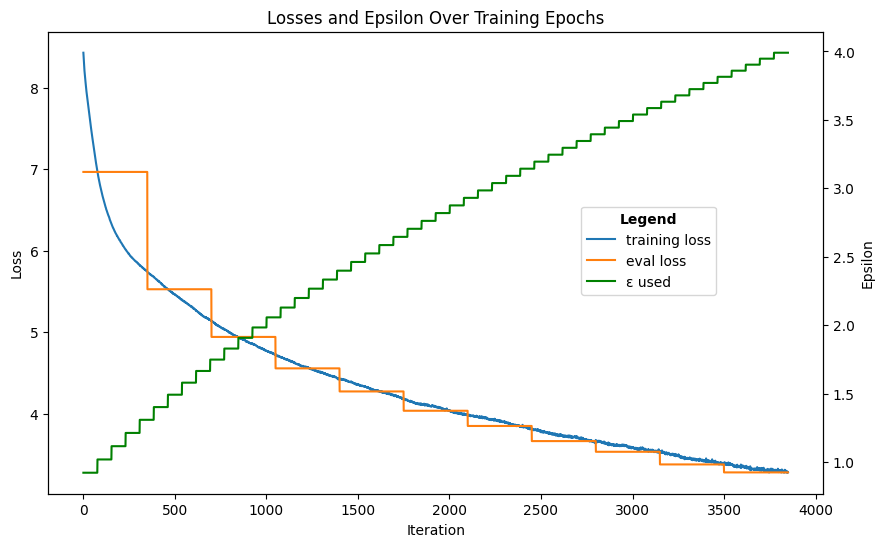

In [20]:
plot_training_curves(trainer, dp_config,
                    savepath=f'figures/minGPT_DP_{dataset_size}_eps{dp_config.target_epsilon}_training_plot_2.pdf')

In [22]:
# Save final model
saved_model_path = f'models/saved/minGPT/DP/minGPT_DP_{dataset_size}_eps4.pth'
torch.save(dp_model, saved_model_path)

print(f"Training completed!\nSaved model at {saved_model_path}")

Training completed!
Saved model at models/saved/minGPT/DP/minGPT_DP_medium_eps4.pth


In [37]:
# Generate synthetic samples
TRAIN_DATA = f'data/sources/json/{dataset_size}/train_gts_with_pop.json'
train_data = json.load(open(TRAIN_DATA, 'r'))

sample_ids = list(train_data.keys())
num_samples = 5
num_mutations = 50

synthetic_sequences = []
for i,sample in enumerate(sample_ids[:num_samples]):
    print(f"\nGenerating sample {i+1}...")
    start_prompt = train_data[sample]['genotypes'][:100]  # Use first 100 chars of genotype as prompt
    sequence = generate_synthetic_samples(
        dp_model,
        tokenizer,
        max_sample_length=5*num_mutations,
        return_tensors=False,
        start_prompt=start_prompt,
    )
    synthetic_sequences.extend(sequence)
    print(f"Generated sequence {i+1}: {sequence[-1][len(sequence[-1])-100:]}...\n")  # Show last 100 chars

synthetic_sequences


Generating sample 1...
Generated sequence 1: 0|0 22:23699082:C>T_0|0 22:18023:G>A_0|0 22:35432180:A>C_0|0 22:41127604:C>T_0|0 22:47080011:G>A_0|0...


Generating sample 2...
Generated sequence 2:  22:26022459:G>A_0|0 22:42605583:A>G_0|0 22:26676959:C>T_0|0 22:49590617:G>A_0|0 22:19002159:C>T_0|0...


Generating sample 3...
Generated sequence 3: 22:464803650:G>A_0|0 22:27655242:T>C_0|0 22:49241557:G>A_0|0 22:45713518:C>T_0|0 22:16508084:A>C_0|0...


Generating sample 4...
Generated sequence 4: 22:240090069:A>G_0|0 22:42536373:G>A_0|0 22:38562455:A>G_0|0 22:19525655:C>T_0|0 22:36395438:A>G_0|0...


Generating sample 5...
Generated sequence 5: |0 22:397849:C>T_0|0 22:20784826:G>A_0|0 22:20719003:G>A_0|0 22:48608009:G>A_0|0 22:33791078:G>T_0|0...



['22:16056839:C>T_0|0 22:16059249:G>A_0|0 22:16059670:A>G_0|0 22:16059958:G>T_0|0 22:16061929:T>G_0|0 22:20211559:G>A_0|0 22:34724270:T>A_0|0 22:28426696:G>T_0|0 22:44444960:C>T_0|0 22:2531803:A>G_0|1 22:48719522:G>A_0|0 22:48707463:T>C_0|0 22:26255190:A>G_0|0 22:47616632:A>G_0|0 22:20784826:G>A_0|0 22:42965069:CAT>C_0|0 22:42205583:G>A_0|0 22:23235524:G>A_0|0 22:35539979:C>T_0|0 22:40498512:G>C_0|0 22:43772969:A>C_0|0 22:40022878:G>A_0|0 22:33618782:T>C_0|0 22:45272045:T>G_0|0 22:45265263:T>C_0|0 22:23272793:G>A_0|0 22:23173329:A>G_0|0 22:30632684:A>G_0|0 22:17443906:T>C_0|0 22:50942761:A>G_0|0 22:42547055:G>A_0|0 22:37083177:C>G_0|0 22:42596921:C>T_0|0 22:27594653:C>T_0|0 22:47496628:G>A_0|0 22:46512356:G>A_0|0 22:49177909:G>A_0|0 22:40544271:C>T_0|0 22:31280894:A>G_0|0 22:30977060:G>A_0|0 22:19421625:T>G_0|0 22:50220973:C>T_0|0 22:17556466:G>A_0|0 22:47826083:T>A_0|0 22:41783251:G>A_0|0 22:30731882:C>T_0|0 22:44863532:G>A_0|0 22:49333421:C>T_0|0 22:46870847:G>A_0|0 22:17556466:G>A_0

___

### Inference

In [39]:
# Load trained model
saved_model_path = f'models/saved/minGPT/DP/minGPT_DP_{dataset_size}.pth'
dp_model = MinGPT.from_pretrained(saved_model_path)
print(dp_model)

MinGPT(
  (transformer): ModuleDict(
    (wte): Embedding(4104, 128)
    (wpe): Embedding(512, 128)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-3): 4 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=128, out_features=384, bias=False)
          (c_proj): Linear(in_features=128, out_features=128, bias=False)
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=128, out_features=512, bias=False)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=512, out_features=128, bias=False)
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=128, out_features=4104, bias=False)
)


In [ ]:
dp_config = MinGPTConfig(dataset_size, use_privacy=True)
dp_config.max_length = 1024 #4676 # max sample length
dp_config.block_size = 1024 #4676 # block size

# Load trained tokenizer
tokenizer = RegexTokenizer()
tokenizer.load()
GPT_SPECIAL_TOKENS = {'<START_SAMPLE>': 4096,
                    '<END_SAMPLE>': 4097,
                    '<MUT_SEP>': 4098,
                    '<START_ID>': 4099,
                    '<END_ID>': 4100,
                    '<START_POP>': 4101,
                    '<END_POP>': 4102,
                    '<PAD>': 4103,
                    '<UNK>': 4104}
tokenizer.register_special_tokens(GPT_SPECIAL_TOKENS)
tokenizer.special_tokens = GPT_SPECIAL_TOKENS

# create trainer with trained model
trainer = MinGPTTrainer(config=dp_config, model=dp_model.to('cpu'), tokenizer=tokenizer)

Using local MPS (Apple Silicon GPU)
Running on device: mps


In [41]:
# Generate synthetic samples
TRAIN_DATA = f'data/sources/json/{dataset_size}/train_gts_with_pop.json'
train_data = json.load(open(TRAIN_DATA, 'r'))

sample_ids = list(train_data.keys())
num_samples = 50
num_mutations = 500

synthetic_sequences = []
for i,sample in enumerate(sample_ids[:num_samples]):
    print(f"\nGenerating sample {i+1}...")
    start_prompt = train_data[sample]['genotypes'][:100]  # Use first 100 chars of genotype as prompt
    sequence = trainer.generate_synthetic_samples(
        max_sample_length=20*num_mutations,
        return_tensors=False,
        start_prompt=start_prompt,
    )
    synthetic_sequences.extend(sequence)
    print(f"Generated sequence {i+1}: {sequence[-1][:100]}...\n")  # Show first 100 chars


Generating sample 1...
Generated sequence 1: 22:16050679:G>A_0|0 22:16052097:G>A_0|0 22:16053979:G>A_0|0 22:16054888:A>G_0|0 22:16055054:G>T_0|0 ...


Generating sample 2...
Generated sequence 2: 22:16050679:G>A_0|0 22:16052097:G>A_0|0 22:16053979:G>A_0|0 22:16054888:A>G_0|0 22:16055054:G>T_0|0 ...


Generating sample 3...
Generated sequence 3: 22:16050679:G>A_0|0 22:16052097:G>A_0|0 22:16053979:G>A_0|0 22:16054888:A>G_0|0 22:16055054:G>T_0|0 ...


Generating sample 4...
Generated sequence 4: 22:16050679:G>A_0|0 22:16052097:G>A_0|0 22:16053979:G>A_0|0 22:16054888:A>G_0|0 22:16055054:G>T_0|0 ...


Generating sample 5...
Generated sequence 5: 22:16050679:G>A_0|0 22:16052097:G>A_0|0 22:16053979:G>A_0|0 22:16054888:A>G_0|0 22:16055054:G>T_0|0 ...


Generating sample 6...
Generated sequence 6: 22:16050679:G>A_0|0 22:16052097:G>A_0|0 22:16053979:G>A_0|0 22:16054888:A>G_0|0 22:16055054:G>T_0|0 ...


Generating sample 7...
Generated sequence 7: 22:16050679:G>A_0|0 22:16052097:G>A_0|0 22:16053

In [42]:
synthetic_genotypes = {f'synth_{i+1}': seq for i, seq in enumerate(synthetic_sequences)}

with open(f'data/generated/json/minGPT/mingpt_dp.json', 'w+') as f:
    json.dump(synthetic_genotypes, f)

In [43]:
from metrics import *
from data.data_utils import get_sequences_from_file

valid_sequences, valid_sequences_ratio, all_sequences = get_valid_sequences(synthetic_genotypes.values(),
                                                                            sample_wise=True)
training_gts = get_sequences_from_file(f'data/sources/json/{dataset_size}/train_gts_with_pop.json')
training_gts = [gt['genotypes'] for gt in training_gts]
original_valid_sequences, original_valid_sequences_ratio, all_original_sequences = get_valid_sequences(training_gts, has_sample_names=True)

unique_muts_gpt_pretrained, memorized_muts_gpt_pretrained = get_new_generated_mutations(valid_sequences,
                                                            original_sequences=all_original_sequences,
                                                            sample_wise=True)

Total muts: 2528 >> Unique: 2487, Memorized: 41
Total muts: 2636 >> Unique: 2604, Memorized: 32
Total muts: 2622 >> Unique: 2586, Memorized: 36
Total muts: 2648 >> Unique: 2598, Memorized: 50
Total muts: 2592 >> Unique: 2547, Memorized: 45
Total muts: 2570 >> Unique: 2525, Memorized: 45
Total muts: 2583 >> Unique: 2542, Memorized: 41
Total muts: 2627 >> Unique: 2573, Memorized: 54
Total muts: 2595 >> Unique: 2555, Memorized: 40
Total muts: 2601 >> Unique: 2563, Memorized: 38
Total muts: 2594 >> Unique: 2540, Memorized: 54
Total muts: 2597 >> Unique: 2562, Memorized: 35
Total muts: 2623 >> Unique: 2584, Memorized: 39
Total muts: 2573 >> Unique: 2536, Memorized: 37
Total muts: 2597 >> Unique: 2558, Memorized: 39
Total muts: 2552 >> Unique: 2512, Memorized: 40
Total muts: 2594 >> Unique: 2550, Memorized: 44
Total muts: 2577 >> Unique: 2532, Memorized: 45
Total muts: 2613 >> Unique: 2571, Memorized: 42
Total muts: 2696 >> Unique: 2661, Memorized: 35
Total muts: 2490 >> Unique: 2438, Memori

In [44]:
unique_sequences, unique_sequences_ratio = get_uniqueness_score(valid_sequences)
unique_sequences_ratio

[0.10680379746835443,
 0.11760242792109256,
 0.11746758199847444,
 0.10687311178247734,
 0.10262345679012345,
 0.1085603112840467,
 0.11691831204026326,
 0.10239817282070804,
 0.10597302504816955,
 0.11803152633602461,
 0.10254433307632999,
 0.11089718906430497,
 0.105604269919939,
 0.1154294597745822,
 0.1105121293800539,
 0.12029780564263323,
 0.1117964533538936,
 0.11175785797438882,
 0.1148105625717566,
 0.11980712166172107,
 0.11164658634538152,
 0.10802469135802469,
 0.09939637826961771,
 0.1177352830896138,
 0.10347520499804763,
 0.10814927646610815,
 0.10633397312859885,
 0.10553158101216163,
 0.115625,
 0.10933940774487472,
 0.1043849437330229,
 0.10391104294478527,
 0.10154193305754043,
 0.10762160091918806,
 0.10772277227722772,
 0.10574712643678161,
 0.11220249338874197,
 0.10286611700039262,
 0.11582134746404239,
 0.1120414673046252,
 0.11124076234928043,
 0.10317460317460317,
 0.10228136882129278,
 0.11225658648339061,
 0.11294117647058824,
 0.10540752351097178,
 0.099145

In [45]:
rare_muts = open(f'data/sources/rare_snps.txt', 'r').readlines()
rare_muts = [mut.strip('\n') for mut in rare_muts]
common_muts = open(f'data/sources/common_snps.txt', 'r').readlines()
common_muts = [mut.strip('\n') for mut in common_muts]

memorized_rare, memorized_common = [0 for _ in memorized_muts_gpt_pretrained], [0 for _ in memorized_muts_gpt_pretrained]
rare_muts_gts = [0 for _ in memorized_muts_gpt_pretrained]
common_muts_gts = [0 for _ in memorized_muts_gpt_pretrained]
for i, sample in enumerate(memorized_muts_gpt_pretrained):
    for mut in sample:
        mut, gt = mut.split('_')
        if mut in rare_muts:
            memorized_rare[i] += 1
            if gt != '0|0':
                rare_muts_gts[i] += 1
        elif mut in common_muts:
            memorized_common[i] += 1
            if gt != '0|0':
                common_muts_gts[i] += 1

print("Analysed %d mutations:" % sum([len(s) for s in memorized_muts_gpt_pretrained]))
print("  Found %d rare mutations" % np.sum(memorized_rare))
print("     of which %d non-ref" % np.sum(rare_muts_gts))
print("  Found %d common mutations" % np.sum(memorized_common))
print("     of which %d non-ref" % np.sum(common_muts_gts))

Analysed 2158 mutations:
  Found 2017 rare mutations
     of which 0 non-ref
  Found 141 common mutations
     of which 0 non-ref


___

In [22]:
from data.data_utils import corpus_to_VCF
import json

with open(f'data/generated/json/minGPT/mingpt_dp.json', 'r') as f:
    synthetic_genotypes = json.load(f)

corpus_to_VCF(synthetic_genotypes, imputation_method=f'mingpt_dp', allowed_chroms=22)

Gathering mutation information from corpus: 100%|██████████| 50/50 [00:00<00:00, 270.58it/s]


Found 15176 unique mutations in 1 chromosomes.


Writing mutations to VCF: 15176it [00:00, 26309.23it/s]


Generated VCF saved to 'data/generated/vcfs/minGPT/mingpt_dp.chr22.50_samples.vcf'.


'data/generated/vcfs/minGPT/mingpt_dp.chr22.50_samples.vcf'